In [1]:
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scipy.stats import binomtest
import pingouin as pg

In [2]:
mother, father = ['CAR2493_F', 'CAR2494_M']

samples_lst = pd.read_csv('./data/interim/samples.txt', header=None)[0].to_list()
print(samples_lst)

['CAR2463', 'CAR2464', 'CAR2465', 'CAR2466', 'CAR2467', 'CAR2468', 'CAR2469', 'CAR2470', 'CAR2471', 'CAR2472', 'CAR2473', 'CAR2474', 'CAR2475', 'CAR2476', 'CAR2477', 'CAR2478', 'CAR2479', 'CAR2480', 'CAR2481', 'CAR2482', 'CAR2483', 'CAR2484', 'CAR2485', 'CAR2486', 'CAR2487', 'CAR2488', 'CAR2489', 'CAR2490', 'CAR2491', 'CAR2492', 'CAR2493_F', 'CAR2494_M']


## Check mendelian by own filtering

In [3]:
# variants = pd.read_csv('./data/interim/bams/cohort.merged.table', sep='\t')
# variants = pd.read_csv('./data/interim/cor/cohort.merged.table', sep='\t')

variants = pd.read_parquet('./data/interim/cor/cohort.merged.flt.snpgap.parents.parquet')
variants = variants[(variants.CHROM != 'NC_001606.1')]
print(len(variants))
variants[[x for x in variants.columns if x.endswith('.DP')]].median()

13902377


CAR2463.DP      21.0
CAR2464.DP      21.0
CAR2465.DP      20.0
CAR2466.DP      21.0
CAR2467.DP      21.0
CAR2468.DP      20.0
CAR2469.DP      18.0
CAR2470.DP      21.0
CAR2471.DP      20.0
CAR2472.DP      20.0
CAR2473.DP      20.0
CAR2474.DP      20.0
CAR2475.DP      18.0
CAR2476.DP      21.0
CAR2477.DP      21.0
CAR2478.DP      21.0
CAR2479.DP      20.0
CAR2480.DP      20.0
CAR2481.DP      20.0
CAR2482.DP      20.0
CAR2483.DP      20.0
CAR2484.DP      19.0
CAR2485.DP      17.0
CAR2486.DP      20.0
CAR2487.DP      20.0
CAR2488.DP      21.0
CAR2489.DP      20.0
CAR2490.DP      20.0
CAR2491.DP      20.0
CAR2492.DP      20.0
CAR2493_F.DP    21.0
CAR2494_M.DP    21.0
dtype: float64

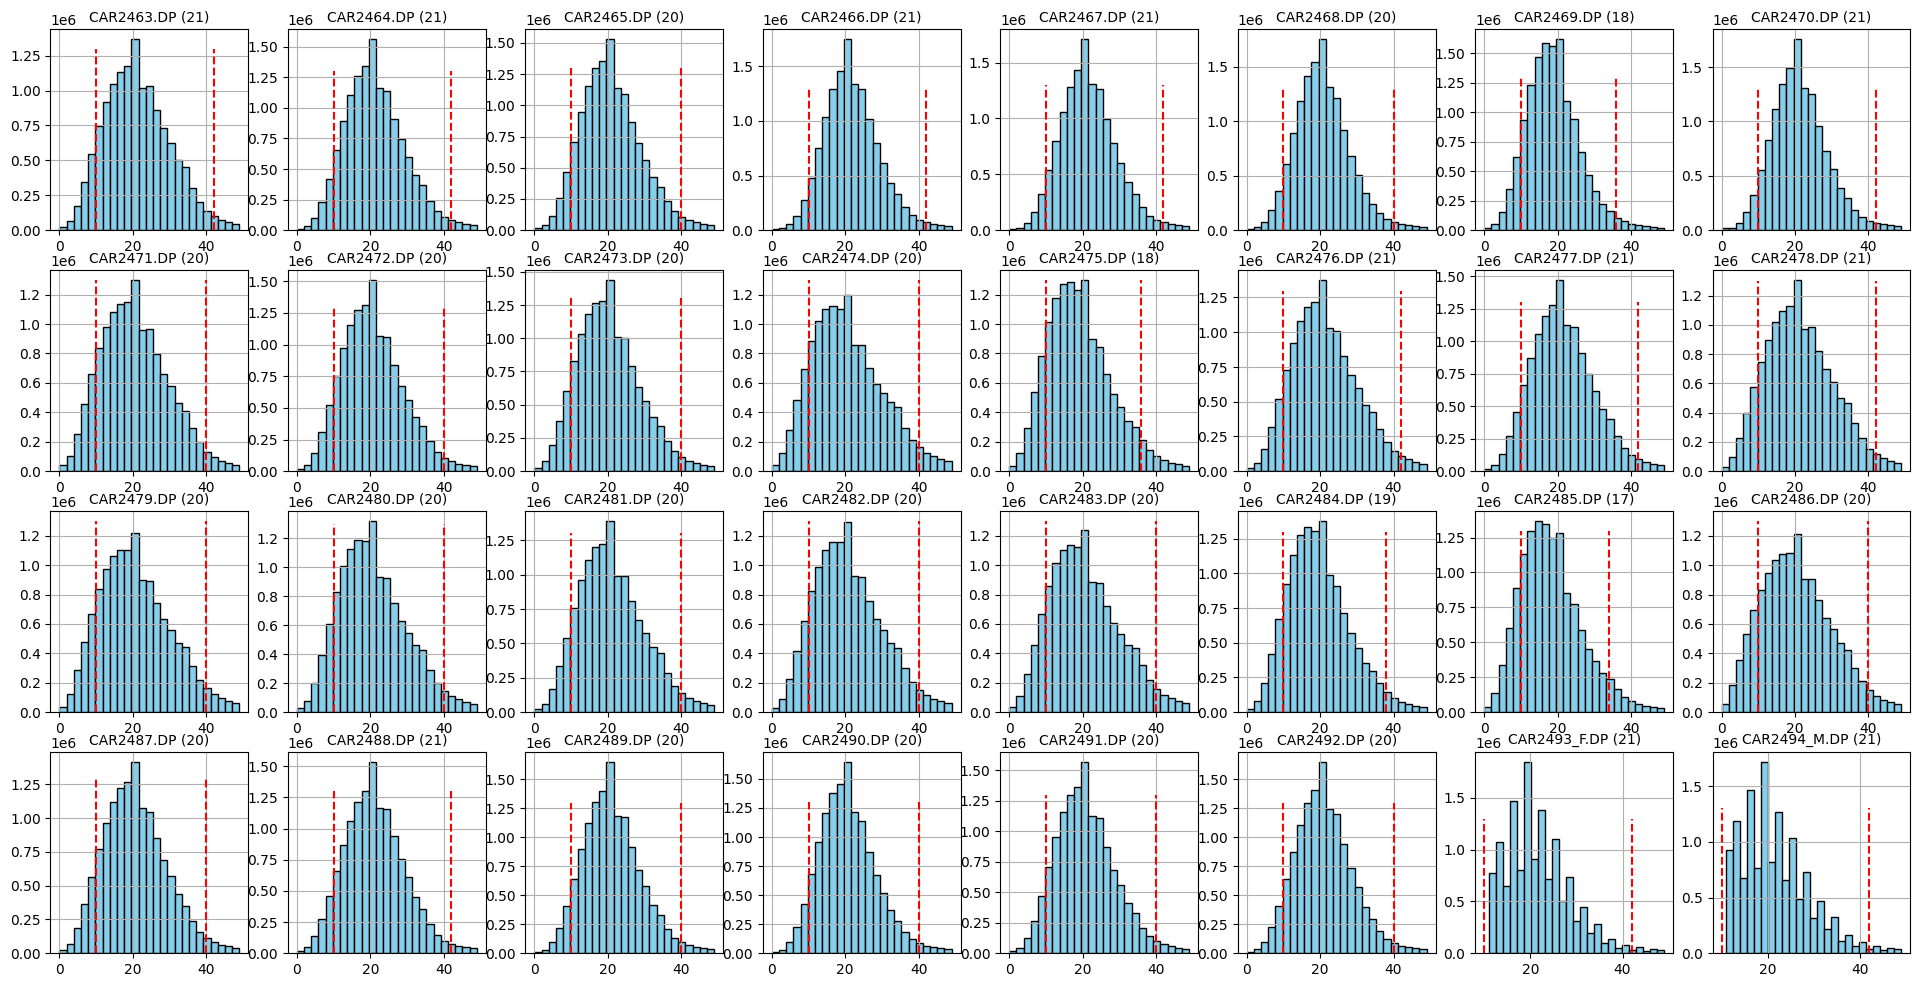

In [18]:
plt.figure(figsize=(24, 12))
for i,s in enumerate([x for x in variants.columns if '.DP' in x], 1):
    plt.subplot(4, 8, i)
    variants[s][variants[s]<50].hist(bins=25, color='skyblue', edgecolor='black')
    _median = int(variants[s].median())
    plt.title(f'{s} ({_median})', fontsize=10)
    plt.vlines([10, _median*2], 0, 1.3e6, 'r', 'dashed')

plt.savefig('./figures/samples_DP.pdf')
plt.show()

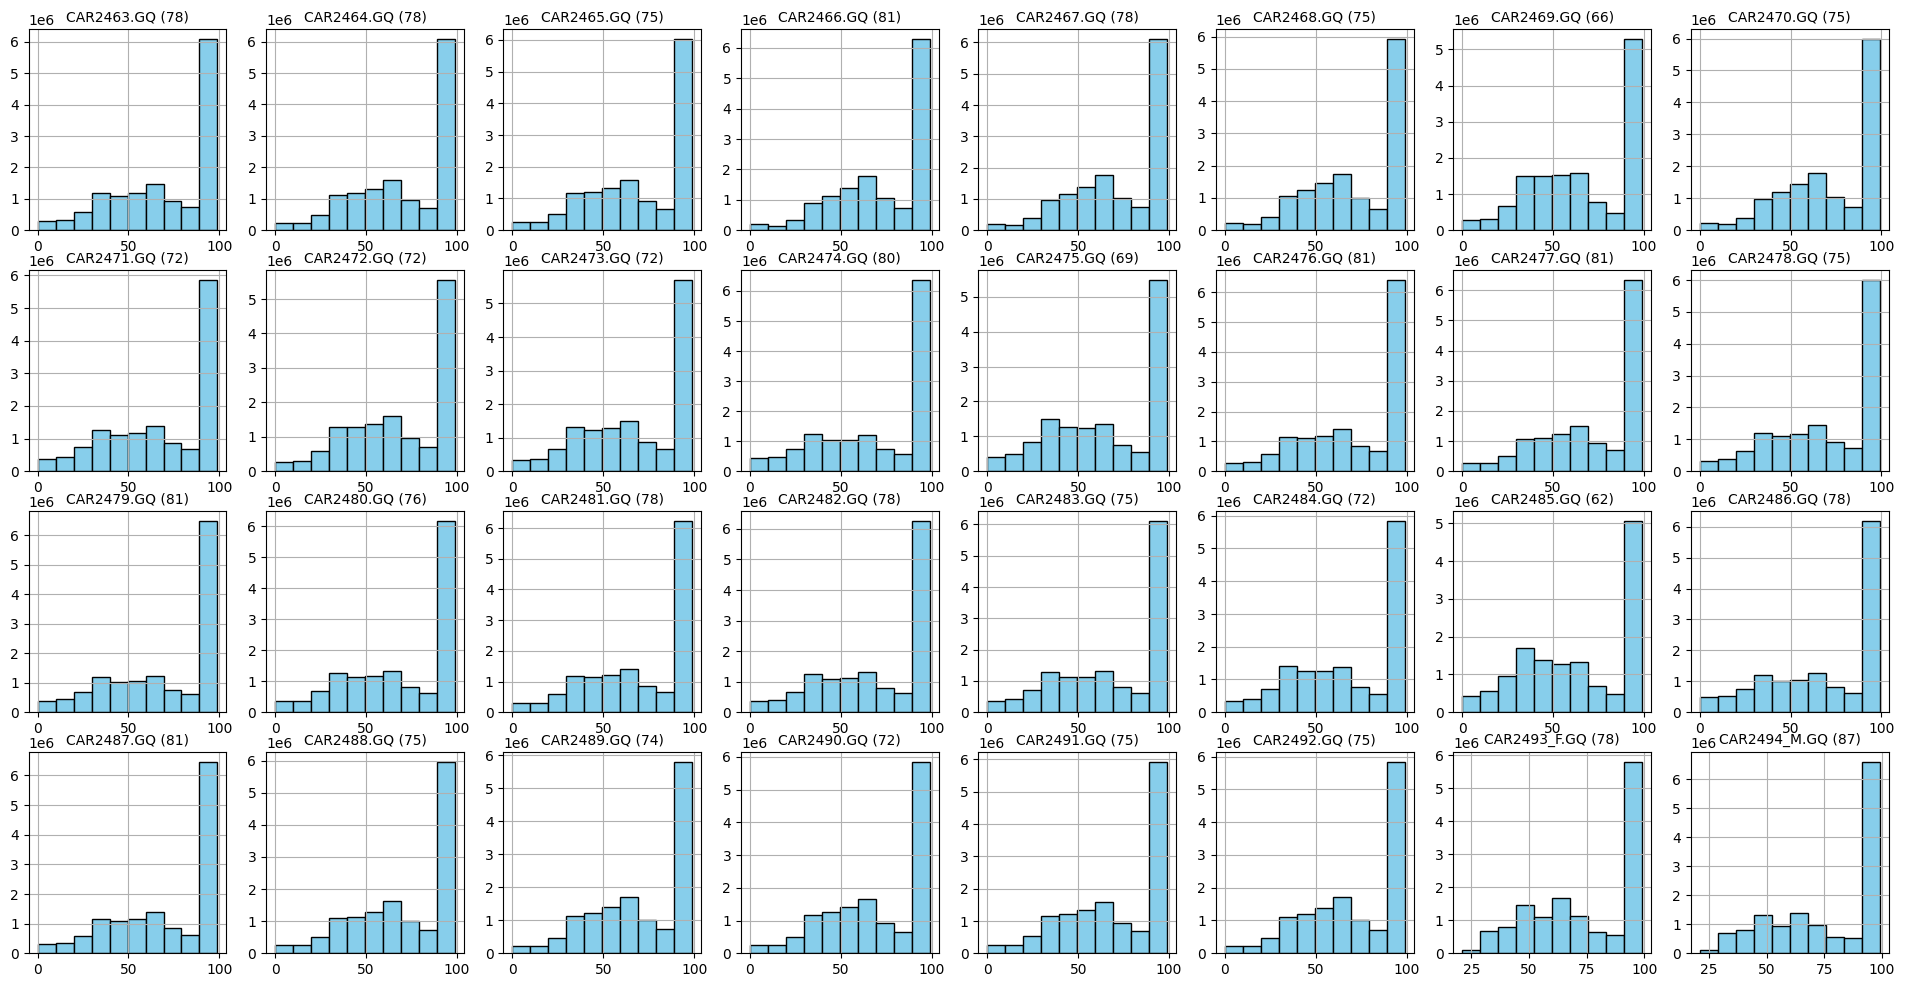

In [5]:
plt.figure(figsize=(24, 12))
for i,s in enumerate([x for x in variants.columns if '.GQ' in x], 1):
    plt.subplot(4, 8, i)
    variants[s].hist(bins=10, color='skyblue', edgecolor='black')
    _median = int(variants[s].median())
    plt.title(f'{s} ({_median})', fontsize=10)

plt.savefig('./figures/samples_GQ.pdf')
plt.show()

In [9]:
variants.head()

,CHROM,POS,TYPE,hiConfDeNovo,CAR2463.GT,CAR2463.DP,CAR2463.AD,CAR2463.PL,CAR2463.GQ,CAR2464.GT,...,CAR2493_F.GT,CAR2493_F.DP,CAR2493_F.AD,CAR2493_F.PL,CAR2493_F.GQ,CAR2494_M.GT,CAR2494_M.DP,CAR2494_M.AD,CAR2494_M.PL,CAR2494_M.GQ
80,NC_056572.1,25480,SNP,None,T|T,15.0,"[0, 15]","[664, 45, 0]",45.0,G|T,...,G|T,22.0,"[12, 10]","[380, 0, 463]",99.0,T|T,34.0,"[0, 34]","[1510, 102, 0]",99.0
81,NC_056572.1,25482,SNP,None,G|G,15.0,"[0, 15]","[664, 45, 0]",45.0,C|G,...,C|G,22.0,"[12, 10]","[380, 0, 463]",99.0,G|G,34.0,"[0, 34]","[1510, 102, 0]",99.0
82,NC_056572.1,25608,SNP,None,G/G,14.0,"[14, 0]","[0, 42, 484]",42.0,G|C,...,G/G,32.0,"[32, 0]","[0, 77, 984]",77.0,G|C,22.0,"[15, 7]","[246, 0, 609]",99.0
83,NC_056572.1,25615,SNP,None,G/G,14.0,"[14, 0]","[0, 42, 484]",42.0,G|T,...,G/G,32.0,"[32, 0]","[0, 93, 1395]",93.0,G|T,21.0,"[15, 6]","[207, 0, 612]",99.0
84,NC_056572.1,25700,INDEL,None,AT|A,10.0,"[5, 5]","[145, 0, 141]",99.0,AT/AT,...,AT/AT,21.0,"[21, 0]","[0, 60, 777]",60.0,AT|A,16.0,"[9, 7]","[182, 0, 293]",99.0


In [10]:
def filter_by_PL(pl: list):
    srted = sorted(pl)
    return srted[1] - srted[0] > 20

def filter_by_only_2_AD(ad: list):
    return len(ad) == 2 or 1 <= sum([x > 0 for x in ad]) <= 2

def filter_by_mend_variants(row: pd.Series, proband: str):
    """filter out mendelian variants !!!!ERROR"""

    if filter_by_PL(row[proband+'.PL']) == False:
        return False

    if filter_by_only_2_AD(row[proband+'.AD']) == False:
        return False

    mom_gt = set(row[mother+'.GT'].replace('|', '/').split('/'))
    fat_gt = set(row[father+'.GT'].replace('|', '/').split('/'))
    pro_gt = set(row[proband+'.GT'].replace('|', '/').split('/'))

    cond1 = bool(pro_gt.intersection(mom_gt))
    cond2 = bool(pro_gt.intersection(fat_gt))

    return cond1 != cond2


def calc_allele_balance(AD: list):
    """Here we define allelic balance as the   fraction  of reads supporting the alternative allele 
    out of the reads supporting the   reference  and alternative alleles
    """
    return sum(AD[1:]) / sum(AD)


def estimate_minimal_ad(coverage_median):
    for i in range(1, coverage_median):
        res = binomtest(i, coverage_median)
        if res.pvalue >= 0.05:
            break
    return i

In [8]:
basic_cols = ['CHROM', 'POS', 'TYPE', 'hiConfDeNovo']
ad_min = estimate_minimal_ad(20) # 6
print(ad_min)

6


In [65]:
collected_mend_errs = []

for i, proband in enumerate(samples_lst[:-2], 1):
    if proband == 'CAR2471':
        continue

    fam_cols = []
    for S in [proband, mother, father]:
        for CC in ['GT', 'AD', 'PL', 'GQ', 'DP']:
            fam_cols.append(S+'.'+CC)

    cur_df: pd.DataFrame = variants[basic_cols + fam_cols]#.head(100000) # TODO drop head
    # print(len(cur_df))

    # basic filters
    _median = cur_df[proband+'.DP'].median()
    cur_df = cur_df[(cur_df[proband+'.DP'].between(ad_min*2, _median)) & (cur_df[proband+'.GQ'] > 20)].copy()
    # print(len(cur_df))

    # cur_df = cur_df[
    #     (cur_df[proband+'.PL'].apply(filter_by_PL)) &
    #     (cur_df[proband+'.AD'].apply(filter_by_only_2_AD))
    # ]
    # print(len(cur_df))

    #  For heterozygous calls, AB between 0.25 and 0.75 is considered balanced
    # cur_df['proband_ab'] = cur_df[proband+'.AD'].apply(lambda x: sum(x[1:]) / sum(x))
    # cur_df = cur_df[cur_df['proband_ab'].between(0.25, 0.75)]
    # print(len(cur_df))

    # must contain ALT allele with AD >= 6
    # cur_df = cur_df[cur_df[proband+'.AD'].apply(lambda x: x[0] >= ad_min)]
    # cur_df = cur_df[cur_df[proband+'.AD'].apply(lambda x: x[0] >= 10 and x[1] >= 10)]
    
    # select variatns that has hiConfDeNovo according to GATK 
    # - **hiConfDeNovo**  Description="High confidence possible de novo mutation (GQ >= 20 for all trio members)=[comma-delimited list of child samples]">
    # - **loConfDeNovo**  Description="Low confidence possible de novo mutation (GQ >= 10 for child, GQ > 0 for parents)=[comma-delimited list of child samples]">
    # cur_df['DeNovoGATK'] = cur_df.hiConfDeNovo.fillna('').str.contains(proband)
    cur_df = cur_df[cur_df.hiConfDeNovo.fillna('').str.contains(proband)]


    # filter by AD_min for offspring (heterozyg) and parents (homozyg)
    cur_df = cur_df[
        (cur_df[proband+'.AD'].apply(lambda x: x[0] >= ad_min and x[1] >= ad_min)) &
        (cur_df[father+'.AD'].apply(lambda x: x[0] >= ad_min and x[1] <= 1)) &
        (cur_df[mother+'.AD'].apply(lambda x: x[0] >= ad_min and x[1] <= 1))

    ]
    

    # select good variants that are mendelian errors
    # cur_df = cur_df[cur_df.apply(filter_by_mend_variants, axis=1, proband=proband)]

    # filter star-variants '*'
    # cur_df = cur_df[
    #     (~cur_df[proband+'.GT'].str.contains('*', regex=False)) &
    #     (~cur_df[father+'.GT'].str.contains('*', regex=False)) &
    #     (~cur_df[mother+'.GT'].str.contains('*', regex=False))
    # ]
    
    # calculate allele balance
    #  For heterozygous calls, AB between 0.25 and 0.75 is considered balanced
    cur_df['proband_ab'] = cur_df[proband+'.AD'].apply(lambda x: x[1] / sum(x))
    cur_df['mother_ab'] = cur_df[mother+'.AD'].apply(lambda x: x[1] / sum(x))
    cur_df['father_ab'] = cur_df[father+'.AD'].apply(lambda x: x[1] / sum(x))

    # # is homozyg
    # cur_df['proband_homoz'] = cur_df[proband+'.GT'].apply(is_homozyg)
    # cur_df['mother_homoz'] = cur_df[mother+'.GT'].apply(is_homozyg)
    # cur_df['father_homoz'] = cur_df[father+'.GT'].apply(is_homozyg)

    # cur_df = cur_df[cur_df['proband_ab'].between(0.25, 0.75)]
    cur_df = cur_df[
        (cur_df.proband_ab.between(0.25, 0.75)) &
        ((cur_df.mother_ab < 0.05)) &
        ((cur_df.father_ab < 0.05))
    ]

    # 
    # cur_df = cur_df[(cur_df[proband+'.AD'].apply(filter_by_proband)) & \
    #                 (cur_df[mother+'.AD'].apply(filter_by_proband)) & \
    #                 (cur_df[father+'.AD'].apply(filter_by_proband))]

    # cur_df = cur_df[(cur_df[proband+'.GT'] != cur_df[mother+'.GT']) | \
    #                 (cur_df[proband+'.GT'] != cur_df[father+'.GT'])]
    
    # cur_df = cur_df[cur_df.apply(is_mend_err_by_gt_gatk, 1, proband=proband)]

    collected_mend_errs.append(cur_df.copy())
    cur_df.to_csv(f'./data/interim/cor_results/{proband}.dnm_gatk.csv')
    cur_df.to_parquet(f'./data/interim/cor_results/{proband}.dnm_gatk.parquet')

    print(proband, len(cur_df), (cur_df['TYPE'] == 'SNP').sum())
    if i % 10 == 0:
        print()
    

# cur_df
# CAR2463 1260

CAR2463 213 48
CAR2464 236 75
CAR2465 209 46
CAR2466 277 43
CAR2467 242 60
CAR2468 224 54
CAR2469 138 30
CAR2470 234 74
CAR2472 180 60

CAR2473 424 269
CAR2474 937 670
CAR2475 315 226
CAR2476 541 354
CAR2477 510 339
CAR2478 528 383
CAR2479 382 242
CAR2480 481 307
CAR2481 453 309
CAR2482 511 341

CAR2483 289 177
CAR2484 370 232
CAR2485 238 145
CAR2486 496 321
CAR2487 550 356
CAR2488 454 265
CAR2489 513 320
CAR2490 422 236
CAR2491 483 326
CAR2492 482 314



In [31]:
cur_df

4302185

In [33]:
pos_diff = variants['POS'].iloc[1:].values - variants['POS'].iloc[:-1]
pos_diff.describe().round(2)

count    13902376.00
mean            1.76
std         59006.16
min     -48423986.00
25%            10.00
50%            29.00
75%            85.00
max        426324.00
Name: POS, dtype: float64

In [34]:
pos_diff.quantile([0.01, 0.99])

0.01       1.0
0.99    1102.0
Name: POS, dtype: float64

<AxesSubplot:>

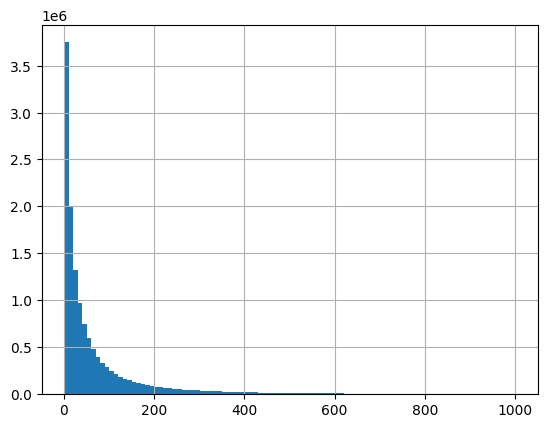

In [35]:
pos_diff[pos_diff.between(1, 1000)].hist(bins=100)

### Check AD of REF and ALT 

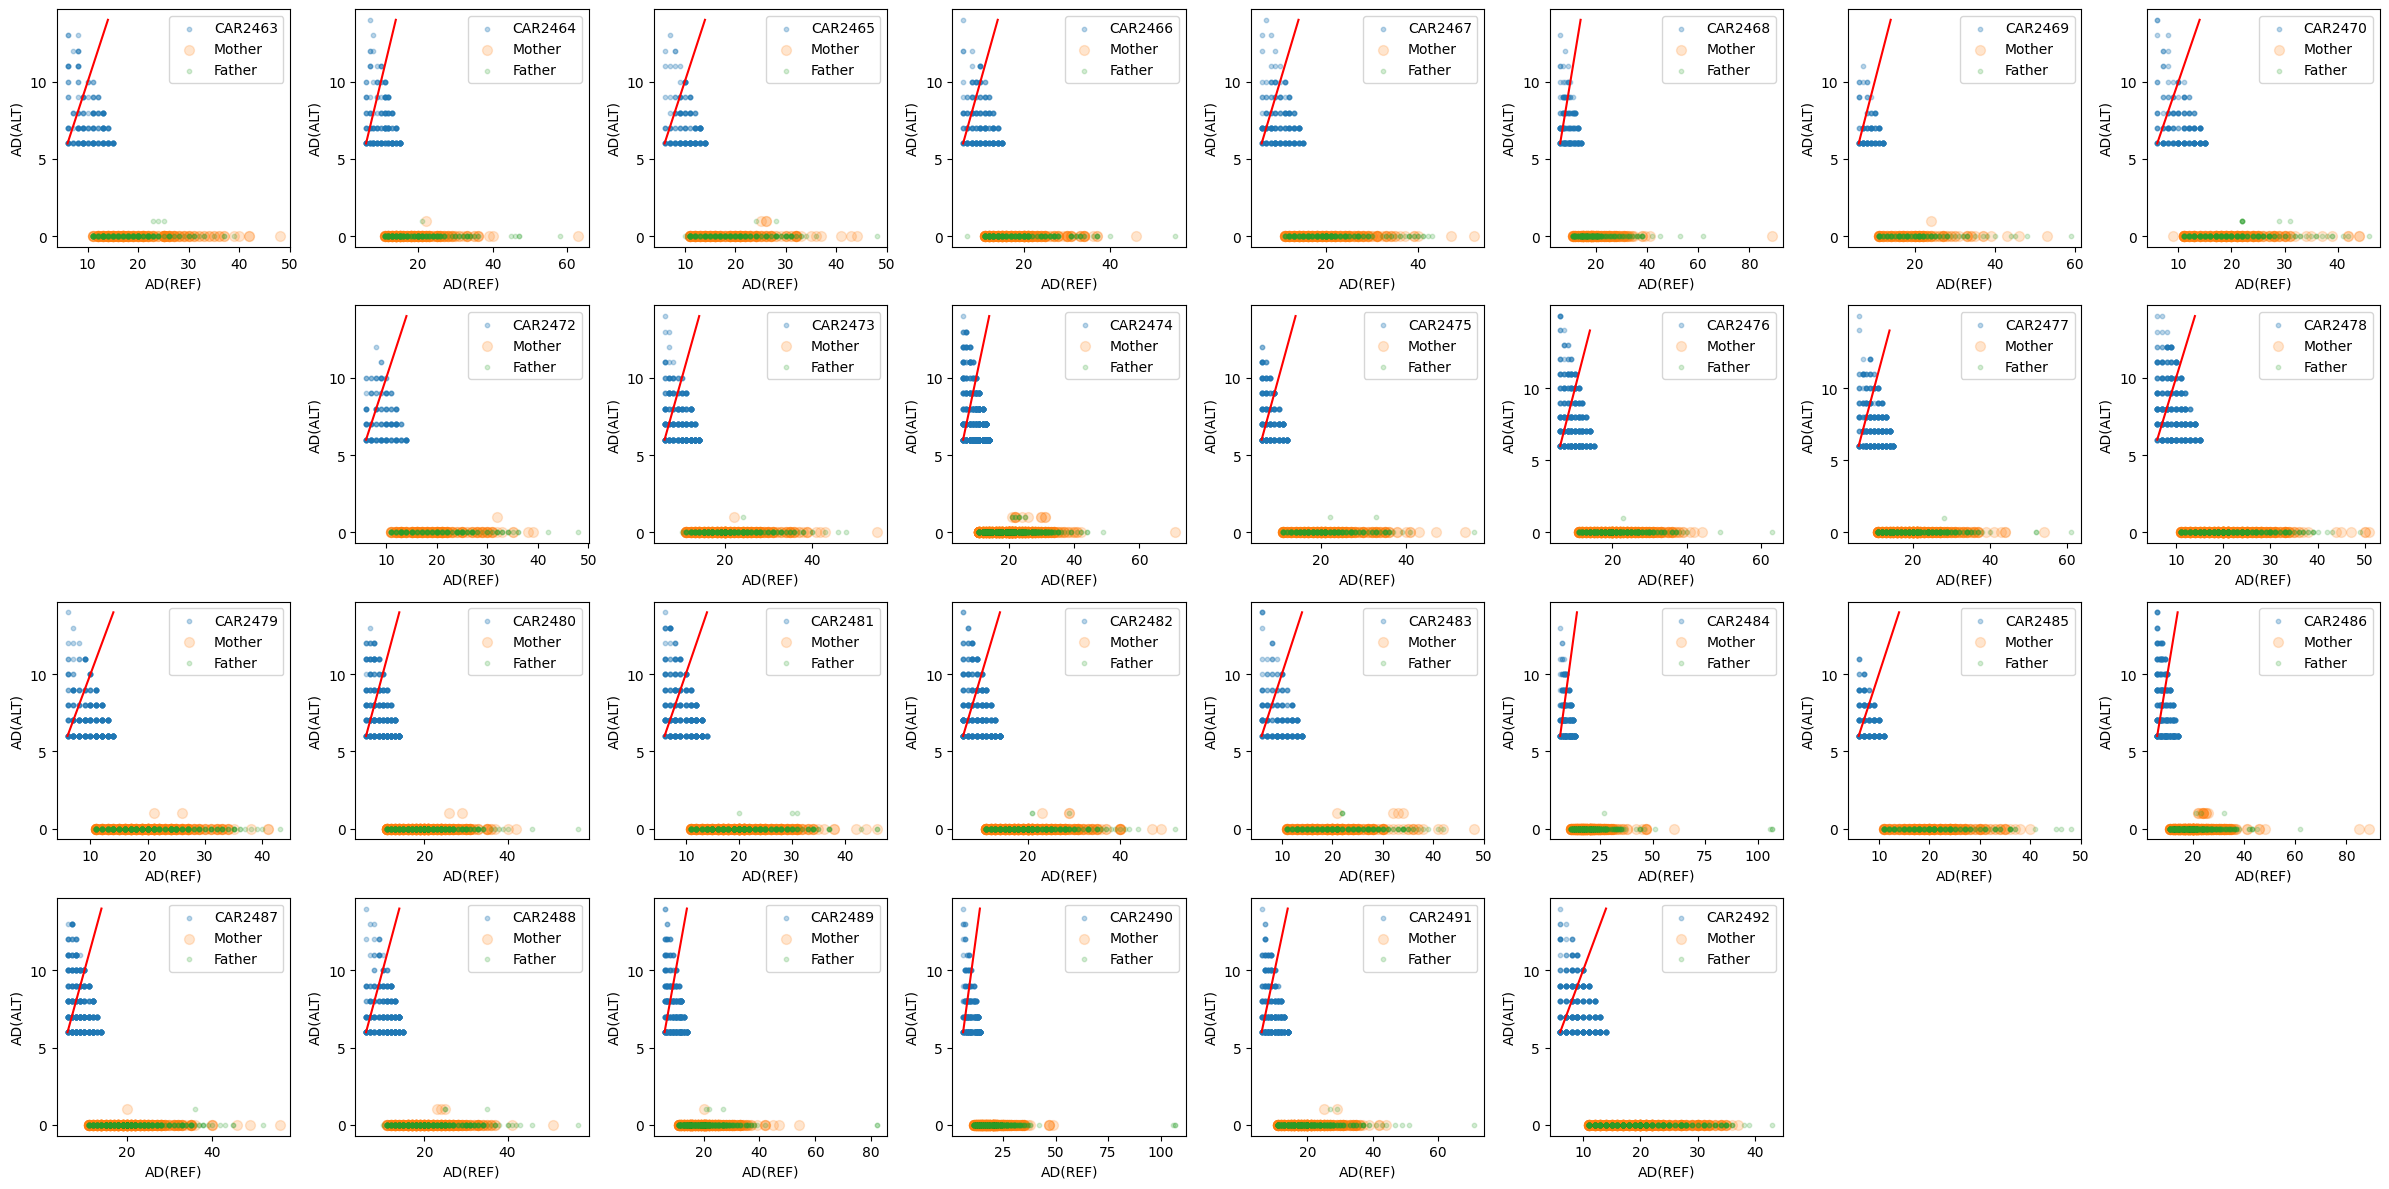

In [81]:
plt.figure(figsize=(24, 12))
for i,proband in enumerate(samples_lst[:30], 1):
    if '71' in proband:
        continue
    cur_df = pd.read_parquet(f'./data/interim/cor_results/{proband}.dnm_gatk.parquet')

    chi_ad = pd.DataFrame(cur_df[proband+'.AD'].to_list(),columns=['ad_ref', 'ad_alt'])
    moz_ad = pd.DataFrame(cur_df[mother+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])
    faz_ad = pd.DataFrame(cur_df[father+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])

    plt.subplot(4, 8, i)

    plt.scatter(chi_ad.ad_ref, chi_ad.ad_alt, alpha=0.3, s=10, label=proband)
    plt.scatter(moz_ad.ad_ref, moz_ad.ad_alt, label='Mother', alpha=0.2, s=50)
    plt.scatter(faz_ad.ad_ref, faz_ad.ad_alt, label='Father', alpha=0.2, s=10)

    plt.plot(np.arange(6, 15), np.arange(6, 15), 'r')
    plt.xlabel('AD(REF)')
    plt.ylabel('AD(ALT)')
    plt.yticks(range(0, 15, 5))
    plt.legend()

plt.tight_layout()
plt.savefig('./figures/samples_ref_alt_AD.pdf')

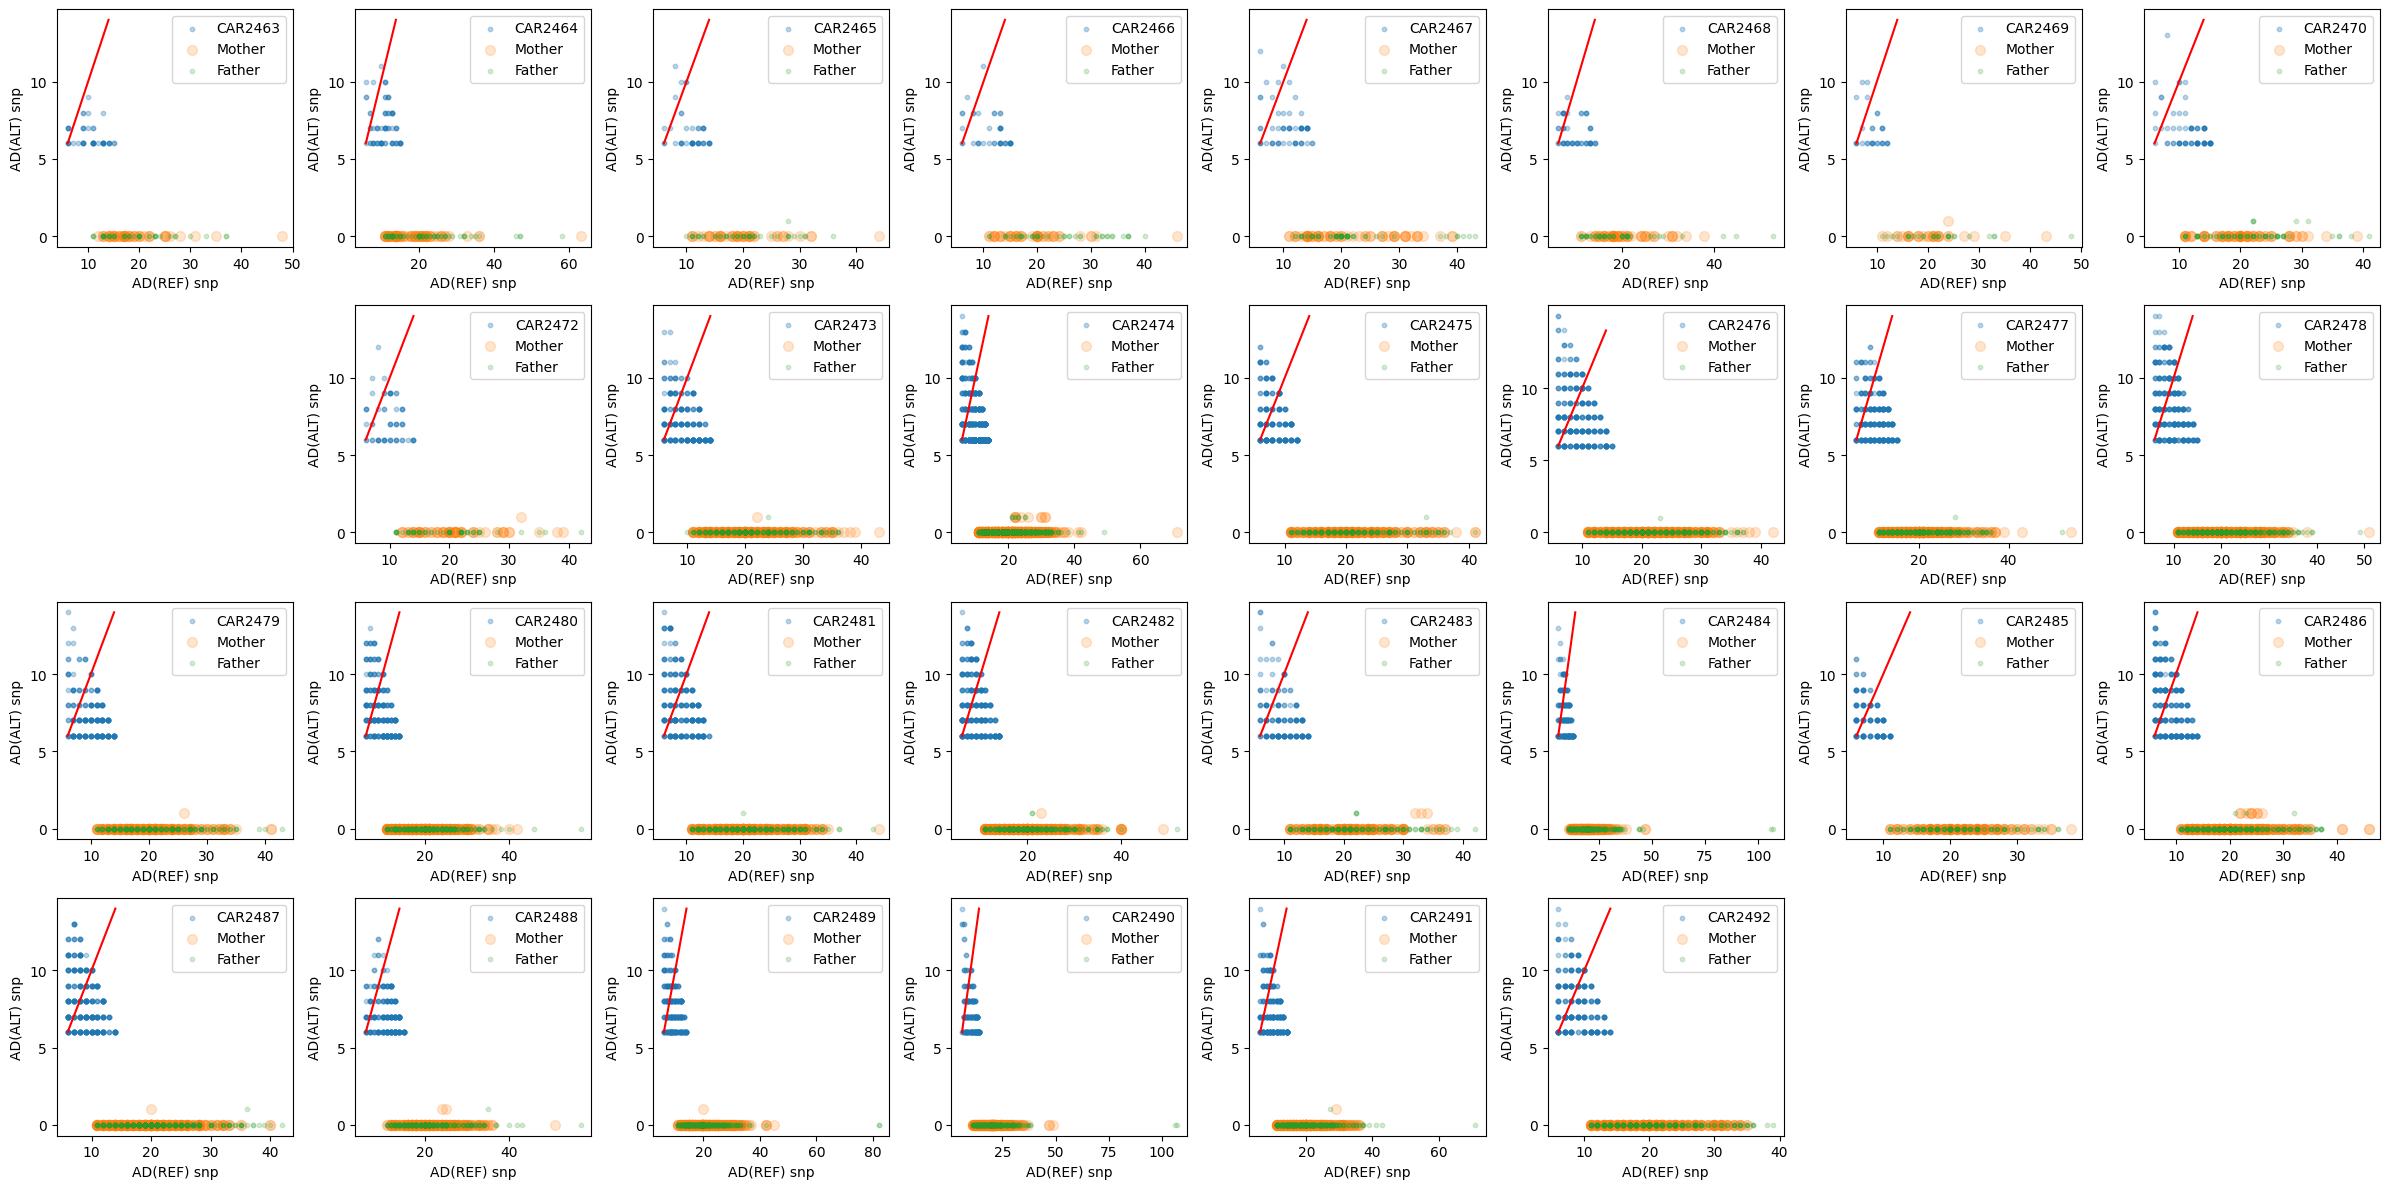

In [82]:
plt.figure(figsize=(24, 12))
for i,proband in enumerate(samples_lst[:30], 1):
    if '71' in proband:
        continue
    cur_df = pd.read_parquet(f'./data/interim/cor_results/{proband}.dnm_gatk.parquet')
    cur_df = cur_df[cur_df.TYPE == 'SNP']

    chi_ad = pd.DataFrame(cur_df[proband+'.AD'].to_list(),columns=['ad_ref', 'ad_alt'])
    moz_ad = pd.DataFrame(cur_df[mother+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])
    faz_ad = pd.DataFrame(cur_df[father+'.AD'].to_list(), columns=['ad_ref', 'ad_alt'])

    plt.subplot(4, 8, i)

    plt.scatter(chi_ad.ad_ref, chi_ad.ad_alt, alpha=0.3, s=10, label=proband)
    plt.scatter(moz_ad.ad_ref, moz_ad.ad_alt, label='Mother', alpha=0.2, s=50)
    plt.scatter(faz_ad.ad_ref, faz_ad.ad_alt, label='Father', alpha=0.2, s=10)

    plt.plot(np.arange(6, 15), np.arange(6, 15), 'r')
    plt.xlabel('AD(REF) snp')
    plt.ylabel('AD(ALT) snp')
    plt.yticks(range(0, 15, 5))
    plt.legend()

plt.tight_layout()
plt.savefig('./figures/samples_ref_alt_AD_snp.pdf')

In [86]:
binomtest(12, 35)

BinomTestResult(k=12, n=35, alternative='two-sided', statistic=0.34285714285714286, pvalue=0.08953107893466952)

In [84]:
binomtest(6, 20)

BinomTestResult(k=6, n=20, alternative='two-sided', statistic=0.3, pvalue=0.11531829833984375)

In [85]:
binomtest(5, 20)

BinomTestResult(k=5, n=20, alternative='two-sided', statistic=0.25, pvalue=0.04138946533203125)

<AxesSubplot:>

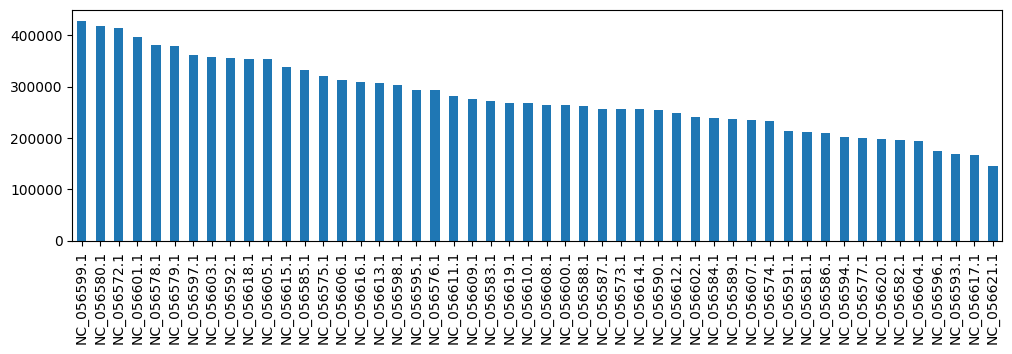

In [87]:
plt.figure(figsize=(12, 3))
variants['CHROM'].value_counts().plot.bar()

Filters:

1. read depth (AD) over 12;
2. Allelic balance between 0.25 and 0.75 - the  fraction  of reads supporting the alternative allele out of the reads supporting the   reference  and alternative allele
3. TODO genotype likelihood difference greater than 20 between the highest and    second-highest scoring genotype (GQ).

https://sciwheel.com/work/item/4248945/resources/10217061/pdf

We extracted de novo candidates from the variants satisfying the following  criteria: 

1. the proband had to be an alternative allele carrier; 
2. **for homozygous alternative allele carriers**, we only considered candidates with ≤   1 read supporting the  reference allele; 
3. minimum depth in the **parent** of **12** reads for the autosomes and 6 reads for hemizygous chromosomes; 
4. maximum of 1 read supporting the alternative allele in the parent; 
5. parent allelic balance <= 0.05;
6. minimum depth of 12 reads for proband;
7. proband allelic balance >= 0.15;
8. maximum of 10 possible and 3 likely carriers beyond the descendants of the parent pair; 
9. maximum of 10% average soft clipping per read covering the DNM candidate. 

In [7]:

# def is_mend_err_by_gt_gatk(ser: pd.Series, proband):
#     # hiConfDeNovo CONTAIN THIS INFO
#     trio = ser.loc[proband+'.GT'], ser.loc[mother+'.GT'], ser.loc[father+'.GT']
#     pgt, mgt, fgt = [set(x.replace('|', '/').split('/')) for x in trio]

#     is_m_child = bool(pgt.difference(mgt))
#     is_f_child = bool(pgt.difference(fgt))

#     return is_m_child or is_f_child

In [94]:
labels = ['ctrl'] * 9 + ['nem-shok'] * 10 + ['nem'] * 10
dnms = pd.DataFrame(list(zip(samples_lst[:-2], 
                             [len(x) for x in collected_mend_errs], 
                             [len(x[x.TYPE == 'SNP']) for x in collected_mend_errs])), 
                    columns=['sample', 'dnm', 'dnm_snp'])
dnms['grp'] = labels
dnms

,sample,dnm,dnm_snp,grp
0,CAR2463,213,48,ctrl
1,CAR2464,236,75,ctrl
2,CAR2465,209,46,ctrl
3,CAR2466,277,43,ctrl
4,CAR2467,242,60,ctrl
5,CAR2468,224,54,ctrl
6,CAR2469,138,30,ctrl
7,CAR2470,234,74,ctrl
8,CAR2471,180,60,ctrl
9,CAR2472,424,269,nem-shok


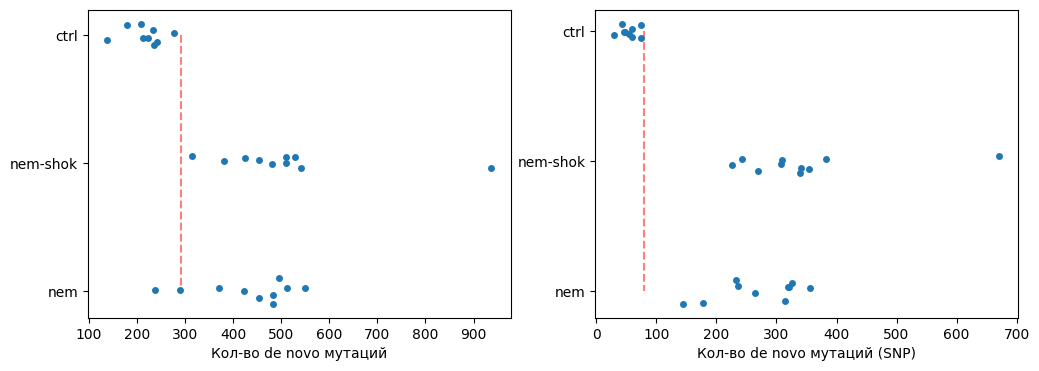

In [97]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.stripplot(dnms, x='dnm', y='grp')

max_ctrl_val = dnms[(dnms['grp'] == 'ctrl')]['dnm'].max()
plt.vlines(max_ctrl_val * 1.05, 0, 2, 'red', 'dashed', '0.02', alpha=0.5,)

plt.xlabel('Кол-во de novo мутаций')
plt.ylabel('')

plt.subplot(122)
sns.stripplot(dnms, x='dnm_snp', y='grp')

max_ctrl_val = dnms[(dnms['grp'] == 'ctrl')]['dnm_snp'].max()
plt.vlines(max_ctrl_val * 1.05, 0, 2, 'red', 'dashed', '0.02', alpha=0.5,)

plt.xlabel('Кол-во de novo мутаций (SNP)')
plt.ylabel('')


plt.savefig('./figures/dnm_counts.pdf');
plt.show()

## Annotate DNMs

### Annotation

In [3]:
def extract_pos(location: str):
    raw_pos = location.split(':')[1]
    if '-' in raw_pos:
        pos = int(raw_pos.split('-')[0])
    else:
        pos = int(raw_pos)
    return pos

In [4]:
# CSQ Format: Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|SOURCE|data.gff.gz

ann = pd.read_csv('data/interim/cor/cohort.merged.flt.snpgap.dnm_gatk.annotated.table', sep='\t')

# check correct splitting
for i in range(len(ann)):
    assert len(set([x[0] for x in ann.loc[i, 'CSQ'].split('|,')])) == 1

# extract valuable info
decipered_ann = pd.DataFrame((ann['CSQ'].apply(lambda x: np.array(x.split('|,')[0].split('|'))[[1,2,7]])).to_list(), 
             columns=['Consequence','IMPACT', 'BIOTYPE'])

ann = ann.join(decipered_ann)
del ann['TYPE']
ann

,CHROM,POS,CSQ,Consequence,IMPACT,BIOTYPE
0,NC_056572.1,41845,T|splice_polypyrimidine_tract_variant&splice_r...,splice_polypyrimidine_tract_variant&splice_reg...,LOW,protein_coding
1,NC_056572.1,318101,A|intron_variant|MODIFIER|LOC109063250|1090632...,intron_variant,MODIFIER,protein_coding
2,NC_056572.1,340862,TTTTTTTT|intergenic_variant|MODIFIER||||||||||...,intergenic_variant,MODIFIER,
3,NC_056572.1,425431,T|intron_variant|MODIFIER|LOC109063396|1090633...,intron_variant,MODIFIER,protein_coding
4,NC_056572.1,582503,T|upstream_gene_variant|MODIFIER|LOC122148703|...,upstream_gene_variant,MODIFIER,protein_coding
...,...,...,...,...,...,...
10943,NC_056621.1,23631465,C|intron_variant|MODIFIER|LOC122142355|1221423...,intron_variant,MODIFIER,protein_coding
10944,NC_056621.1,23645727,T|intergenic_variant|MODIFIER|||||||||||||||||...,intergenic_variant,MODIFIER,
10945,NC_056621.1,23653990,-|intergenic_variant|MODIFIER|||||||||||||||||...,intergenic_variant,MODIFIER,
10946,NC_056621.1,23722034,AC|intron_variant|MODIFIER|LOC109074181|109074...,intron_variant,MODIFIER,protein_coding


### Repeats

In [5]:
# https://www.animalgenome.org/bioinfo/resources/manuals/RepeatMasker.html
#    SW  perc perc perc  query      position in query           matching       repeat              position in  repeat
# score  div. del. ins.  sequence    begin     end    (left)    repeat         class/family         begin  end (left)   ID
#  1320 15.6  6.2  0.0  HSU08988  6563 6781 (22462) C  MER7A   DNA/MER2_type    (0)  337  104  20

#   1320     = Smith-Waterman score of the match, usually complexity adjusted
#         The SW scores are not always directly comparable. Sometimes
#         the complexity adjustment has been turned off, and a variety of
#         scoring-matrices are used dependent on repeat age and GC level.

#   15.6     = % divergence = mismatches/(matches+mismatches) **
#   6.2      = % of bases opposite a gap in the query sequence (deleted bp)
#   0.0      = % of bases opposite a gap in the repeat consensus (inserted bp)
#   HSU08988 = name of query sequence
#   6563     = starting position of match in query sequence
#   6781     = ending position of match in query sequence
#   (22462)  = no. of bases in query sequence past the ending position of match
#   C        = match is with the Complement of the repeat consensus sequence
#   MER7A    = name of the matching interspersed repeat
#   DNA/MER2_type = the class of the repeat, in this case a DNA transposon 
#             fossil of the MER2 group (see below for list and references)
#   (0)      = no. of bases in (complement of) the repeat consensus sequence 
#              prior to beginning of the match (0 means that the match extended 
#              all the way to the end of the repeat consensus sequence)
#   337      = starting position of match in repeat consensus sequence
#   104      = ending position of match in repeat consensus sequence
#   20       = unique identifier for individual insertions 

_cols = [
    'SQ score', 'perc_div', 'perc_del', 'perc_ins', 'chrom', 'begin', 'end', 'left1', 
    'C', 'matching_repeat', 'repeat_class', 'rep_begin', 'rep_end', 'left2', 'ID',
]
repeats = pd.read_csv('data/ref/GCF_018340385.1.repeatModeler.out', 
                      sep='\s+', comment='#', header=None, names=_cols)
repeats = repeats[repeats['chrom'].str.startswith('NC_056')]
repeats

,SQ score,perc_div,perc_del,perc_ins,chrom,begin,end,left1,C,matching_repeat,repeat_class,rep_begin,rep_end,left2,ID
2,20,8.0,0.0,0.0,NC_056572.1,1778,1804,(39503019),+,(T)n,Simple_repeat,1,27,(0),1
3,508,18.4,4.4,6.5,NC_056572.1,1873,2075,(39502748),C,rnd-3_family-1949,DNA/PiggyBac,(164),203,5,2
4,427,13.6,2.6,13.0,NC_056572.1,1968,2119,(39502704),+,rnd-1_family-611,DNA/CMC-EnSpm,41,178,(1),3
5,233,9.8,0.0,11.3,NC_056572.1,2120,2156,(39502667),+,rnd-5_family-5021,LTR/ERV1,2174,2203,(628),4
6,34,6.8,5.9,4.3,NC_056572.1,2157,2224,(39502599),+,(CA)n,Simple_repeat,1,69,(0),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4167167,997,1.6,0.8,0.0,NC_056621.1,24465525,24465650,(654),C,rnd-1_family-632,DNA/TcMar,(1),127,1,3920648
4167168,1635,5.6,2.1,7.0,NC_056621.1,24465665,24465950,(354),C,rnd-4_family-2680,RC/Helitron,(38),493,221,3920649
4167169,47,0.0,0.0,0.0,NC_056621.1,24465951,24465992,(312),+,(TTA)n,Simple_repeat,1,42,(0),3920650
4167170,1017,7.5,0.0,0.7,NC_056621.1,24466024,24466171,(133),C,rnd-4_family-2680,RC/Helitron,(384),147,1,3920649


<AxesSubplot:>

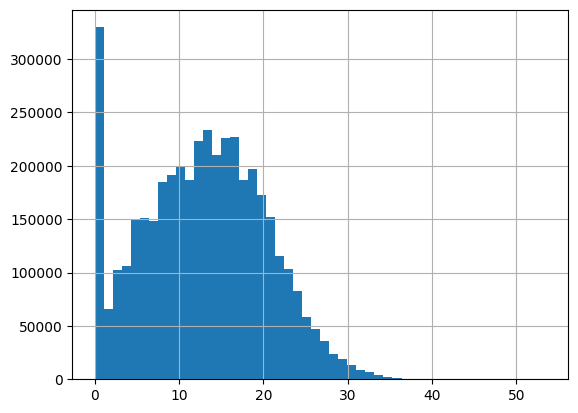

In [5]:
repeats['perc_div'].hist(bins=50)

In [6]:
def is_low_complex_region(chrom: str, pos: int):
    repeats_cur = repeats[(repeats.chrom == chrom) & \
                        (repeats.begin <= pos) & \
                        (repeats.end >= pos)]
    n = len(repeats_cur)
    return n > 0

### Annotate

In [7]:
import os

In [8]:
_chrom_pos_data = []
for i,proband in enumerate(samples_lst[:30], 1):
    if '71' in proband or os.path.exists(f'./data/interim/cor_results/{proband}.dnm_gatk.ann.parquet'):
        continue
    cur_df = pd.read_parquet(f'./data/interim/cor_results/{proband}.dnm_gatk.parquet')
    cur_df['is_low_complex_region'] = cur_df.apply(lambda x: is_low_complex_region(x.CHROM, x.POS), axis=1)
    cur_df['ALLELE'] = cur_df[proband+'.GT'].apply(lambda x: x.replace('|', '/').split('/')[1])
    cur_df = cur_df.merge(ann, 'left', ['CHROM', 'POS'])
    # cur_df = cur_df[cur_df.TYPE == 'SNP']
    _chrom_pos_data.append(cur_df[['CHROM', 'POS']])
    cur_df.to_parquet(f'./data/interim/cor_results/{proband}.dnm_gatk.ann.parquet')
    print(proband, len(cur_df), sum(cur_df.is_low_complex_region))

# pd.concat(_chrom_pos_data).drop_duplicates().sort_values(['CHROM', 'POS']).to_csv(
#     './data/interim/cor/dnm_locations.tsv', sep='\t', index=False, header=None)
cur_df

CAR2490 422 161
CAR2491 483 187
CAR2492 482 158


,CHROM,POS,TYPE,hiConfDeNovo,CAR2492.GT,CAR2492.AD,CAR2492.PL,CAR2492.GQ,CAR2492.DP,CAR2493_F.GT,...,CAR2494_M.DP,proband_ab,mother_ab,father_ab,is_low_complex_region,ALLELE,CSQ,Consequence,IMPACT,BIOTYPE
0,NC_056572.1,687317,SNP,CAR2492,A/T,"[10, 7]","[224, 0, 323]",99.0,17.0,A/A,...,20.0,0.411765,0.0,0.0,True,T,T|intron_variant|MODIFIER|LOC109079326|1090793...,intron_variant,MODIFIER,protein_coding
1,NC_056572.1,858886,SNP,CAR2492,C/A,"[9, 11]","[368, 0, 279]",99.0,20.0,C/C,...,20.0,0.550000,0.0,0.0,False,A,A|missense_variant|MODERATE|LOC109058520|10905...,missense_variant,MODERATE,protein_coding
2,NC_056572.1,998553,INDEL,"CAR2487,CAR2492",T/TA,"[9, 7]","[166, 0, 226]",99.0,16.0,T/T,...,20.0,0.437500,0.0,0.0,True,TA,A|upstream_gene_variant|MODIFIER|LOC109046545|...,upstream_gene_variant,MODIFIER,protein_coding
3,NC_056572.1,5618416,SNP,CAR2492,A/C,"[12, 6]","[144, 0, 422]",99.0,18.0,A/A,...,34.0,0.333333,0.0,0.0,False,C,C|intergenic_variant|MODIFIER|||||||||||||||||...,intergenic_variant,MODIFIER,
4,NC_056572.1,6290044,SNP,CAR2492,A|T,"[7, 12]","[475, 0, 258]",99.0,19.0,A/A,...,21.0,0.631579,0.0,0.0,False,T,T|intergenic_variant|MODIFIER|||||||||||||||||...,intergenic_variant,MODIFIER,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,NC_056621.1,16847140,SNP,CAR2492,T/C,"[10, 8]","[275, 0, 259]",99.0,18.0,T/T,...,14.0,0.444444,0.0,0.0,False,C,C|intron_variant|MODIFIER|LOC109068238|1090682...,intron_variant,MODIFIER,protein_coding
478,NC_056621.1,18113700,SNP,CAR2492,T/C,"[6, 9]","[288, 0, 190]",99.0,15.0,T/T,...,14.0,0.600000,0.0,0.0,False,C,C|downstream_gene_variant|MODIFIER|LOC10909085...,downstream_gene_variant,MODIFIER,protein_coding
479,NC_056621.1,19127070,SNP,CAR2492,C/T,"[6, 8]","[242, 0, 163]",99.0,14.0,C/C,...,21.0,0.571429,0.0,0.0,True,T,T|intron_variant|MODIFIER|LOC109097386|1090973...,intron_variant,MODIFIER,protein_coding
480,NC_056621.1,20755611,SNP,CAR2492,T/G,"[8, 7]","[209, 0, 234]",99.0,15.0,T/T,...,17.0,0.466667,0.0,0.0,False,G,G|intron_variant|MODIFIER|ankrd27|109070164|Tr...,intron_variant,MODIFIER,protein_coding


## Analyse final

In [3]:
group_df = pd.DataFrame(zip(samples_lst, ['ctrl'] * 10 + ['nem-shok'] * 10 + ['nem'] * 10), 
             columns=['SAMPLE', 'GROUP'])
group_df.head()

,SAMPLE,GROUP
0,CAR2463,ctrl
1,CAR2464,ctrl
2,CAR2465,ctrl
3,CAR2466,ctrl
4,CAR2467,ctrl


In [4]:
dnm_data = []
for i,proband in enumerate(samples_lst[:30], 1):
    if '71' in proband:
        continue
    cur_df = pd.read_parquet(f'./data/interim/cor_results/{proband}.dnm_gatk.ann.parquet')
    del cur_df['ALLELE']
    del cur_df['CSQ']
    # cur_df.columns = cur_df.columns.rename(columns_replacer)
    cur_df['SAMPLE'] = proband
    cur_df.rename(columns=lambda x: x.replace(proband, 'proband'), inplace=True)
    cur_df.rename(columns=lambda x: x.replace(mother, 'mother'), inplace=True)
    cur_df.rename(columns=lambda x: x.replace(father, 'father'), inplace=True)
    cur_df.rename(columns=lambda x: x.replace('_ab', '.AB'), inplace=True)
    for c in ['AD', 'PL']:
        for s in ['proband', 'mother', 'father']:
            cur_df[f'{s}.{c}'] = cur_df[f'{s}.{c}'].apply(lambda x: ','.join([str(i) for i in x]))
    # cur_df['proband.PL']
    dnm_data.append(cur_df)

In [6]:
df_dnm = pd.concat(dnm_data, ignore_index=True).merge(group_df)
df_dnm = df_dnm[
    (~df_dnm.is_low_complex_region) & \
    (df_dnm['father.GQ'] >= 60) & \
    (df_dnm['mother.GQ'] >= 60) & \
    (df_dnm['proband.GQ'] >= 60)
]
df_dnm.to_csv('./data/results/dnm_GQ60.csv', index=False)
df_dnm

,CHROM,POS,TYPE,hiConfDeNovo,proband.GT,proband.AD,proband.PL,proband.GQ,proband.DP,mother.GT,...,father.DP,proband.AB,mother.AB,father.AB,is_low_complex_region,Consequence,IMPACT,BIOTYPE,SAMPLE,GROUP
14,NC_056574.1,5954832,SNP,"CAR2463,CAR2484",G|C,"14,6","210,0,570",99.0,20.0,G/G,...,26.0,0.300000,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2463,ctrl
52,NC_056581.1,7798606,INDEL,CAR2463,T|TGTCACGGTTCATGAATGCACCGTCTC,"12,6","215,0,486",99.0,18.0,T/T,...,24.0,0.333333,0.0,0.0,False,intergenic_variant,MODIFIER,,CAR2463,ctrl
77,NC_056592.1,12678104,INDEL,CAR2463,TG|T,"8,11","438,0,303",99.0,19.0,TG/TG,...,31.0,0.578947,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2463,ctrl
78,NC_056592.1,15101769,INDEL,"CAR2463,CAR2469",TTA|T,"13,7","255,0,525",99.0,20.0,TTA/TTA,...,21.0,0.350000,0.0,0.0,False,upstream_gene_variant,MODIFIER,protein_coding,CAR2463,ctrl
112,NC_056601.1,15820933,INDEL,"CAR2463,CAR2485,CAR2492",C|CATCCATGCGTGATGAAAGACTTCATCCAAATGCAATTCACGGA...,"10,10","390,0,390",99.0,20.0,C/C,...,31.0,0.500000,0.0,0.0,False,5_prime_UTR_variant,MODIFIER,protein_coding,CAR2463,ctrl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11296,NC_056618.1,26129046,INDEL,CAR2492,TGAAACAAAAGA|T,"11,7","261,0,441",99.0,18.0,TGAAACAAAAGA/TGAAACAAAAGA,...,43.0,0.388889,0.0,0.0,False,downstream_gene_variant,MODIFIER,protein_coding,CAR2492,nem
11297,NC_056618.1,26129074,INDEL,CAR2492,TGGATTG|T,"11,6","219,0,444",99.0,17.0,TGGATTG/TGGATTG,...,34.0,0.352941,0.0,0.0,False,downstream_gene_variant,MODIFIER,protein_coding,CAR2492,nem
11298,NC_056618.1,26129082,INDEL,CAR2492,AT|A,"10,6","222,0,402",99.0,16.0,AT/AT,...,35.0,0.375000,0.0,0.0,False,downstream_gene_variant,MODIFIER,protein_coding,CAR2492,nem
11307,NC_056619.1,16483389,SNP,CAR2492,A/T,"7,6","163,0,235",99.0,15.0,A/A,...,28.0,0.461538,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem


In [7]:
df_dnm[(df_dnm['proband.GT'].str.contains('\|'))][['SAMPLE', 'CHROM', 'proband.GT', 'mother.GT', 'father.GT']]

,SAMPLE,CHROM,proband.GT,mother.GT,father.GT
14,CAR2463,NC_056574.1,G|C,G/G,G/G
52,CAR2463,NC_056581.1,T|TGTCACGGTTCATGAATGCACCGTCTC,T/T,T/T
77,CAR2463,NC_056592.1,TG|T,TG/TG,TG/TG
78,CAR2463,NC_056592.1,TTA|T,TTA/TTA,TTA/TTA
112,CAR2463,NC_056601.1,C|CATCCATGCGTGATGAAAGACTTCATCCAAATGCAATTCACGGA...,C/C,C/C
...,...,...,...,...,...
11222,CAR2492,NC_056611.1,A|ATATATATATATTCTGTCCAGTGGTACG,A/A,A/A
11284,CAR2492,NC_056617.1,A|T,A/A,A/A
11296,CAR2492,NC_056618.1,TGAAACAAAAGA|T,TGAAACAAAAGA/TGAAACAAAAGA,TGAAACAAAAGA/TGAAACAAAAGA
11297,CAR2492,NC_056618.1,TGGATTG|T,TGGATTG/TGGATTG,TGGATTG/TGGATTG


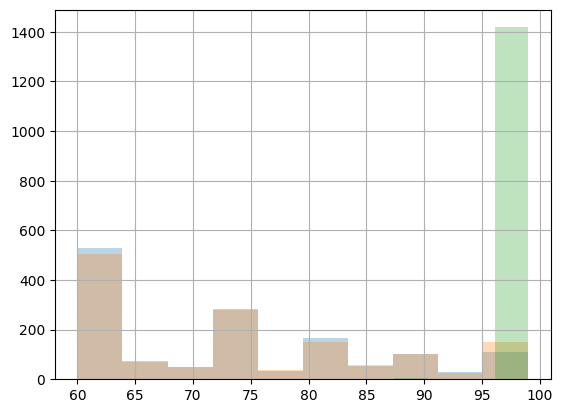

In [141]:
df_dnm['mother.GQ'].hist(alpha=0.3)
df_dnm['father.GQ'].hist(alpha=0.3)
df_dnm['proband.GQ'].hist(alpha=0.3)
plt.savefig('./figures/dnm_GQ60plus_hist.pdf')

<Axes: xlabel='DNM_CNT', ylabel='GROUP'>

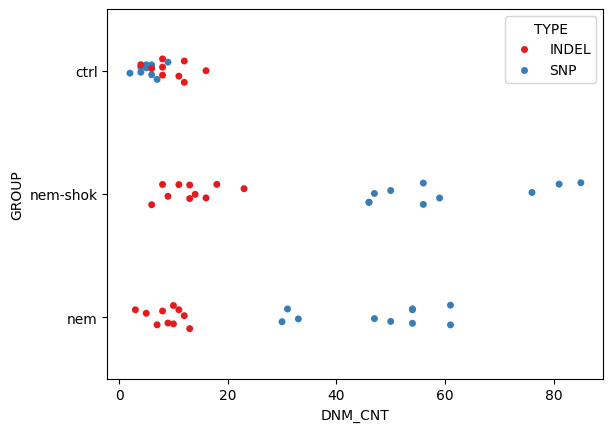

In [8]:
df_dnm_cnt = df_dnm.groupby(['SAMPLE', 'TYPE', ])['GROUP'].value_counts().rename('DNM_CNT').reset_index()
sns.stripplot(df_dnm_cnt, x='DNM_CNT', hue='TYPE', y='GROUP', palette='Set1')
plt.savefig('./figures/DNM_CNT.pdf')

In [9]:
df_dnm_cnt.groupby(['GROUP', 'TYPE']).DNM_CNT.mean().unstack().round(1)

TYPE,INDEL,SNP
GROUP,,
ctrl,9.4,5.3
nem,8.8,47.5
nem-shok,13.1,60.2


In [14]:
_ = df_dnm.groupby(['IMPACT', 'Consequence', 'TYPE'])\
    ['SAMPLE'].value_counts().unstack().fillna(0).astype(int)
_.to_csv('dnm_consequence.csv')
_

SAMPLE                                                             CAR2463  \
IMPACT   Consequence                                        TYPE             
HIGH     frameshift_variant                                 INDEL        0   
         splice_donor_variant                               SNP          0   
         stop_gained                                        SNP          0   
         stop_gained&splice_region_variant                  SNP          0   
LOW      splice_donor_5th_base_variant&intron_variant       SNP          0   
         splice_donor_region_variant&intron_variant         SNP          0   
         splice_polypyrimidine_tract_variant&intron_variant SNP          0   
         splice_polypyrimidine_tract_variant&splice_regi... INDEL        0   
                                                            SNP          0   
         splice_region_variant&synonymous_variant           SNP          0   
         synonymous_variant                                 SNP          0   
MODERATE inframe_deletion                                   INDEL        0   
         missense_variant                                   SNP          0   
         missense_variant&splice_region_variant             SNP          0   
MODIFIER 3_prime_UTR_variant                                INDEL        0   
                                                            SNP          0   
         5_prime_UTR_variant                                INDEL        1   
                                                            SNP          0   
         downstream_gene_variant                            INDEL        4   
                                                            SNP          0   
         intergenic_variant                                 INDEL        1   
                                                            SNP          0   
         intron_variant                                     INDEL        3   
                                                            SNP          2   
         intron_variant&non_coding_transcript_variant       INDEL        0   
                                                            SNP          0   
         non_coding_transcript_exon_variant                 INDEL        0   
                                                            SNP          0   
         upstream_gene_variant                              INDEL        2   
                                                            SNP          0   

SAMPLE                                                             CAR2464  \
IMPACT   Consequence                                        TYPE             
HIGH     frameshift_variant                                 INDEL        0   
         splice_donor_variant                               SNP          0   
         stop_gained                                        SNP          0   
         stop_gained&splice_region_variant                  SNP          0   
LOW      splice_donor_5th_base_variant&intron_variant       SNP          0   
         splice_donor_region_variant&intron_variant         SNP          0   
         splice_polypyrimidine_tract_variant&intron_variant SNP          0   
         splice_polypyrimidine_tract_variant&splice_regi... INDEL        0   
                                                            SNP          0   
         splice_region_variant&synonymous_variant           SNP          0   
         synonymous_variant                                 SNP          0   
MODERATE inframe_deletion                                   INDEL        0   
         missense_variant                                   SNP          0   
         missense_variant&splice_region_variant             SNP          0   
MODIFIER 3_prime_UTR_variant                                INDEL        0   
                                                            SNP          0   
         5_prime_UTR_variant                                INDEL        0   
                     

In [15]:
df_dnm.Consequence.value_counts().head(10)

intron_variant                                  665
intergenic_variant                              302
downstream_gene_variant                         145
upstream_gene_variant                           133
missense_variant                                 48
intron_variant&non_coding_transcript_variant     35
3_prime_UTR_variant                              29
synonymous_variant                               21
5_prime_UTR_variant                              17
stop_gained                                       6
Name: Consequence, dtype: int64

In [7]:
# df_dnm_cnt_impact = df_dnm[df_dnm.IMPACT != 'MODIFIER'].groupby(['GROUP', 'SAMPLE', 'TYPE'])['IMPACT']\
df_dnm_cnt_impact = df_dnm.groupby(['GROUP', 'SAMPLE', 'TYPE'])['IMPACT']\
    .value_counts().unstack().fillna(0).astype(int).join(
        df_dnm.groupby(['GROUP', 'SAMPLE']).TYPE.value_counts().rename('TOTAL'))
df_dnm_cnt_impact['perc.HIGH'] = (df_dnm_cnt_impact['HIGH'] / df_dnm_cnt_impact['TOTAL'] * 100).round(2)
df_dnm_cnt_impact['perc.HIGH&MOD'] = ((df_dnm_cnt_impact['HIGH']+df_dnm_cnt_impact['MODERATE']) / df_dnm_cnt_impact['TOTAL'] * 100).round(2)
df_dnm_cnt_impact = df_dnm_cnt_impact[
    ['perc.HIGH', 'perc.HIGH&MOD', 'HIGH', 'MODERATE', 'MODIFIER', 'LOW', 'TOTAL']]
df_dnm_cnt_impact

perc.HIGH  perc.HIGH&MOD  HIGH  MODERATE  MODIFIER  \
GROUP    SAMPLE  TYPE                                                        
ctrl     CAR2463 INDEL       0.00           0.00     0         0        11   
                 SNP         0.00           0.00     0         0         2   
         CAR2464 INDEL       0.00           0.00     0         0         8   
                 SNP         0.00           0.00     0         0         6   
         CAR2465 INDEL       0.00           0.00     0         0        12   
                 SNP         0.00           0.00     0         0         4   
         CAR2466 INDEL       0.00           0.00     0         0         8   
                 SNP         0.00           0.00     0         0         6   
         CAR2467 INDEL       0.00           0.00     0         0        11   
                 SNP         0.00           0.00     0         0         9   
         CAR2468 INDEL       0.00           0.00     0         0        16   
                 SNP         0.00           0.00     0         0         5   
         CAR2469 INDEL       0.00           0.00     0         0         8   
                 SNP         0.00          25.00     0         1         3   
         CAR2470 INDEL       0.00           0.00     0         0         4   
                 SNP         0.00           0.00     0         0         7   
         CAR2472 INDEL       0.00           0.00     0         0         6   
                 SNP         0.00           0.00     0         0         2   
nem      CAR2483 INDEL       0.00           0.00     0         0         3   
                 SNP         3.23           3.23     1         0        29   
         CAR2484 INDEL       0.00           0.00     0         0        10   
                 SNP         0.00           6.38     0         3        44   
         CAR2485 INDEL       0.00           7.69     0         1        12   
                 SNP         3.33          10.00     1         2        26   
         CAR2486 INDEL       0.00           0.00     0         0         8   
                 SNP         0.00          11.11     0         6        45   
         CAR2487 INDEL       0.00           0.00     0         0        11   
                 SNP         0.00           6.56     0         4        56   
         CAR2488 INDEL       0.00           0.00     0         0         7   
                 SNP         1.85           7.41     1         3        48   
         CAR2489 INDEL       8.33           8.33     1         0        11   
                 SNP         0.00           6.00     0         3        47   
         CAR2490 INDEL       0.00           0.00     0         0        10   
                 SNP         6.06           9.09     2         1        28   
         CAR2491 INDEL       0.00           0.00     0         0         5   
                 SNP         1.85           7.41     1         3        49   
         CAR2492 INDEL       0.00           0.00     0         0         9   
                 SNP         0.00           3.28     0         2        59   
nem-shok CAR2473 INDEL       5.56          11.11     1         1        16   
                 SNP         0.00           0.00     0         0        43   
         CAR2474 INDEL       0.00           0.00     0         0        23   
                 SNP         0.00           2.63     0         2        73   
         CAR2475 INDEL       0.00           0.00     0         0         6   
                 SNP         0.00           6.00     0         3        43   
         CAR2476 INDEL       0.00           0.00     0         0        13   
                 SNP         0.00           2.35     0         2        82   
         CAR2477 INDEL       0.00           0.00     0         0        11   
                 SNP         0.00           3.57     0         2        52   
         CAR2478 INDEL       0.00           0.00     0         0        13   
                 SNP         1.23           8.

In [9]:
df_dnm_cnt_impact[['HIGH', 'MODERATE', 'LOW']].melt(ignore_index=False).reset_index()

,GROUP,SAMPLE,TYPE,variable,value
0,ctrl,CAR2463,INDEL,HIGH,0
1,ctrl,CAR2463,SNP,HIGH,0
2,ctrl,CAR2464,INDEL,HIGH,0
3,ctrl,CAR2464,SNP,HIGH,0
4,ctrl,CAR2465,INDEL,HIGH,0
...,...,...,...,...,...
169,nem-shok,CAR2480,SNP,LOW,1
170,nem-shok,CAR2481,INDEL,LOW,0
171,nem-shok,CAR2481,SNP,LOW,2
172,nem-shok,CAR2482,INDEL,LOW,0


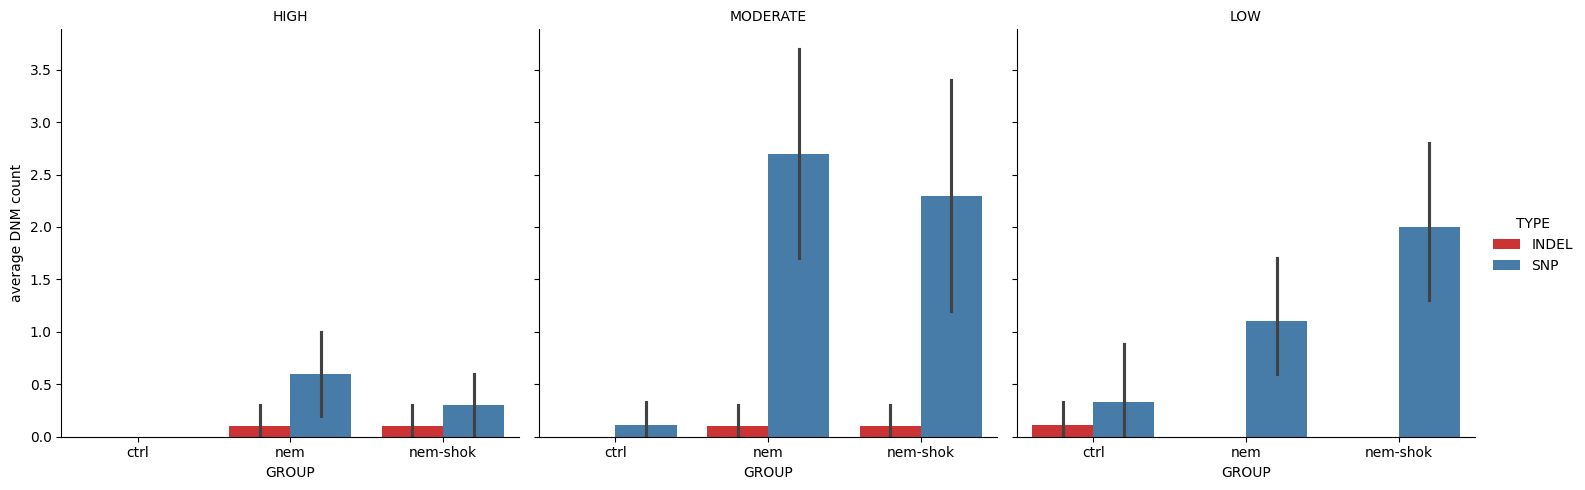

In [11]:
df_dnm_cnt_impact_long = df_dnm_cnt_impact[['HIGH', 'MODERATE', 'LOW']].melt(ignore_index=False).reset_index()

g = sns.catplot(df_dnm_cnt_impact_long, x='GROUP', y='value', 
                hue='TYPE', col='variable', kind='bar', palette='Set1')
g.set_ylabels('average DNM count')
g.set_titles('{col_name}')

In [46]:
pg.pairwise_tests(data=df_dnm_cnt_impact_long[df_dnm_cnt_impact_long['variable'] == 'HIGH'], 
                dv='value', between=['TYPE', 'GROUP'], 
                parametric=False, padjust='bonf').tail(6)

,Contrast,TYPE,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
4,TYPE * GROUP,INDEL,ctrl,nem,False,False,40.5,two-sided,0.399075,1.000000,bonf,-0.415153
5,TYPE * GROUP,INDEL,ctrl,nem-shok,False,False,40.5,two-sided,0.399075,1.000000,bonf,-0.415153
6,TYPE * GROUP,INDEL,nem,nem-shok,False,False,50.0,two-sided,1.000000,1.000000,bonf,0.000000
7,TYPE * GROUP,SNP,ctrl,nem,False,False,22.5,two-sided,0.019574,0.117445,bonf,-1.126561
8,TYPE * GROUP,SNP,ctrl,nem-shok,False,False,31.5,two-sided,0.093290,0.559740,bonf,-0.815345
9,TYPE * GROUP,SNP,nem,nem-shok,False,False,61.5,two-sided,0.334663,1.000000,bonf,0.478136


In [48]:
pg.pairwise_tests(data=df_dnm_cnt_impact_long[df_dnm_cnt_impact_long['variable'] == 'MODERATE'], 
                dv='value', between=['TYPE', 'GROUP'], 
                parametric=False, padjust='bonf').tail(6)

,Contrast,TYPE,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
4,TYPE * GROUP,INDEL,ctrl,nem,False,False,40.5,two-sided,0.399075,1.000000,bonf,-0.415153
5,TYPE * GROUP,INDEL,ctrl,nem-shok,False,False,40.5,two-sided,0.399075,1.000000,bonf,-0.415153
6,TYPE * GROUP,INDEL,nem,nem-shok,False,False,50.0,two-sided,1.000000,1.000000,bonf,0.000000
7,TYPE * GROUP,SNP,ctrl,nem,False,False,5.5,two-sided,0.000708,0.004249,bonf,-2.039715
8,TYPE * GROUP,SNP,ctrl,nem-shok,False,False,10.5,two-sided,0.002603,0.015619,bonf,-1.548640
9,TYPE * GROUP,SNP,nem,nem-shok,False,False,58.5,two-sided,0.535685,1.000000,bonf,0.220774


In [49]:
pg.pairwise_tests(data=df_dnm_cnt_impact_long[df_dnm_cnt_impact_long['variable'] == 'LOW'], 
                dv='value', between=['TYPE', 'GROUP'], 
                parametric=False, padjust='bonf').tail(6)

/home/kpotoh/carp/.venv/lib/python3.10/site-packages/pingouin/effsize.py:803: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / poolsd


,Contrast,TYPE,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
4,TYPE * GROUP,INDEL,ctrl,nem,False,False,50.0,two-sided,0.342782,1.000000,bonf,0.464155
5,TYPE * GROUP,INDEL,ctrl,nem-shok,False,False,50.0,two-sided,0.342782,1.000000,bonf,0.464155
6,TYPE * GROUP,INDEL,nem,nem-shok,False,False,50.0,two-sided,1.000000,1.000000,bonf,NaN
7,TYPE * GROUP,SNP,ctrl,nem,False,False,23.5,two-sided,0.060476,0.362854,bonf,-0.840701
8,TYPE * GROUP,SNP,ctrl,nem-shok,False,False,11.0,two-sided,0.004150,0.024902,bonf,-1.547185
9,TYPE * GROUP,SNP,nem,nem-shok,False,False,29.0,two-sided,0.109084,0.654503,bonf,-0.764208


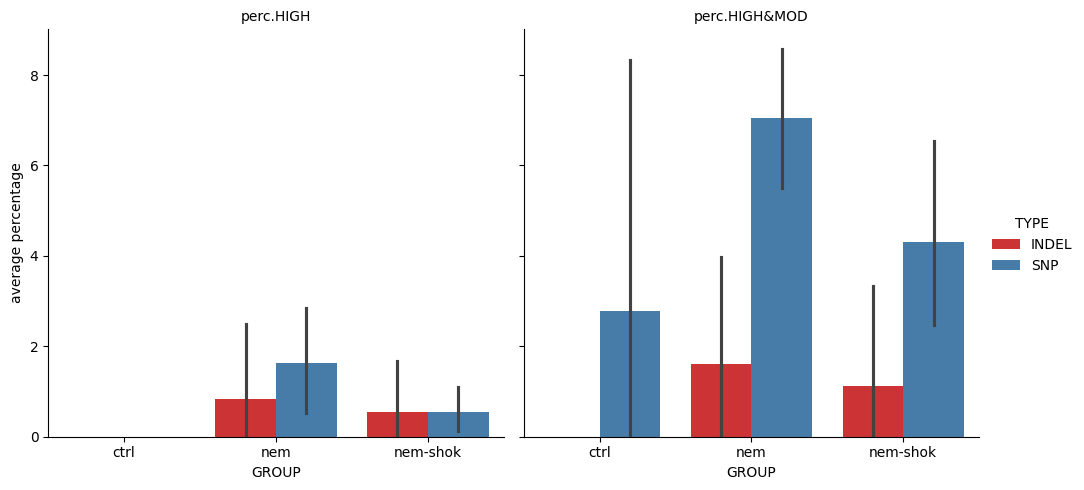

In [ ]:
df_dnm_cnt_impact_long2 = df_dnm_cnt_impact[['perc.HIGH', 'perc.HIGH&MOD']].melt(ignore_index=False).reset_index()

g = sns.catplot(df_dnm_cnt_impact_long2, 
            x='GROUP', y='value', hue='TYPE', col='variable', 
            kind='bar', palette='Set1')
g.set_ylabels('average percentage')
g.set_titles('{col_name}')

In [50]:
pg.pairwise_tests(
    data=df_dnm_cnt_impact_long2[(df_dnm_cnt_impact_long2['variable'] == 'perc.HIGH')&\
                                 (df_dnm_cnt_impact_long2['TYPE'] == 'SNP')], 
    dv='value', between='GROUP', parametric=False, padjust='bonf')

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,GROUP,ctrl,nem,False,False,22.5,two-sided,0.020395,0.061185,bonf,-1.036494
1,GROUP,ctrl,nem-shok,False,False,31.5,two-sided,0.094726,0.284177,bonf,-0.784860
2,GROUP,nem,nem-shok,False,False,63.5,two-sided,0.267126,0.801377,bonf,0.645343


In [51]:
pg.pairwise_tests(
    data=df_dnm_cnt_impact_long2[(df_dnm_cnt_impact_long2['variable'] == 'perc.HIGH&MOD')&\
                                 (df_dnm_cnt_impact_long2['TYPE'] == 'SNP')], 
    dv='value', between='GROUP', parametric=False, padjust='bonf')

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,GROUP,ctrl,nem,False,False,10.0,two-sided,0.003409,0.010228,bonf,-0.677599
1,GROUP,ctrl,nem-shok,False,False,14.0,two-sided,0.008470,0.025410,bonf,-0.234922
2,GROUP,nem,nem-shok,False,False,77.5,two-sided,0.041098,0.123293,bonf,0.880253


In [39]:
df_dnm.groupby(['IMPACT']).Consequence.value_counts().rename('CNT').reset_index()

,IMPACT,Consequence,CNT
0,HIGH,stop_gained,6
1,HIGH,frameshift_variant,2
2,HIGH,splice_donor_variant,2
3,HIGH,stop_gained&splice_region_variant,1
4,LOW,synonymous_variant,21
5,LOW,splice_polypyrimidine_tract_variant&intron_var...,5
6,LOW,splice_donor_region_variant&intron_variant,3
7,LOW,splice_polypyrimidine_tract_variant&splice_reg...,3
8,LOW,splice_donor_5th_base_variant&intron_variant,2
9,LOW,splice_region_variant&synonymous_variant,1


In [40]:
df_dnm.groupby(['GROUP', 'IMPACT']).Consequence.value_counts().rename('CNT').reset_index()

,GROUP,IMPACT,Consequence,CNT
0,ctrl,LOW,synonymous_variant,2
1,ctrl,LOW,splice_donor_region_variant&intron_variant,1
2,ctrl,LOW,splice_polypyrimidine_tract_variant&splice_reg...,1
3,ctrl,MODERATE,missense_variant,1
4,ctrl,MODIFIER,intron_variant,55
5,ctrl,MODIFIER,intergenic_variant,29
6,ctrl,MODIFIER,downstream_gene_variant,18
7,ctrl,MODIFIER,upstream_gene_variant,15
8,ctrl,MODIFIER,intron_variant&non_coding_transcript_variant,4
9,ctrl,MODIFIER,non_coding_transcript_exon_variant,3


### Mutational signature

Expectations: C>T, T>A, T>C

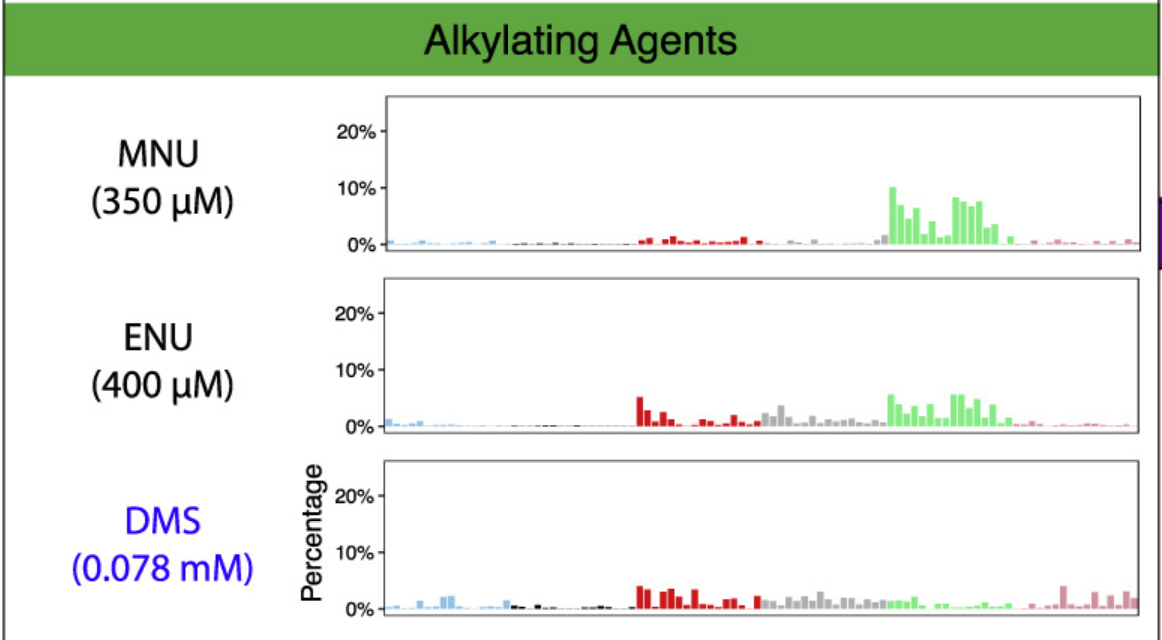

In [12]:
# all parents genotypes are equal
df_dnm[df_dnm['mother.GT'] != df_dnm['father.GT']][['mother.GT', 'father.GT']]

,mother.GT,father.GT
1275,T|T,T/T
1366,C|C,C/C
2481,A|A,A/A
3720,A|A,A/A
3946,A/A,A|A
4057,T/T,T|T
4466,A|A,A/A
4692,C|C,C/C
5410,T|T,T/T
7253,C/C,C|C


In [24]:
_ = df_dnm[df_dnm.TYPE != 'INDEL'][[ 'proband.GT', 'mother.GT', 'father.GT']]
assert (_['proband.GT'].str[0] == _['mother.GT'].str[0]).all()
assert (_['proband.GT'].str[2] != _['mother.GT'].str[0]).all()

df_dnm['Mut'] = df_dnm['mother.GT'].str[0] + '>' + df_dnm['proband.GT'].str[2]
df_dnm[df_dnm.TYPE != 'INDEL'][[ 'proband.GT', 'mother.GT', 'father.GT', 'Mut']]

,proband.GT,mother.GT,father.GT,Mut
14,G|C,G/G,G/G,G>C
190,G/A,G/G,G/G,G>A
225,A|C,A/A,A/A,A>C
267,T/G,T/T,T/T,T>G
342,G/A,G/G,G/G,G>A
...,...,...,...,...
11282,G/A,G/G,G/G,G>A
11284,A|T,A/A,A/A,A>T
11294,T/C,T/T,T/T,T>C
11307,A/T,A/A,A/A,A>T


Text(0, 0.5, 'ObsNum')

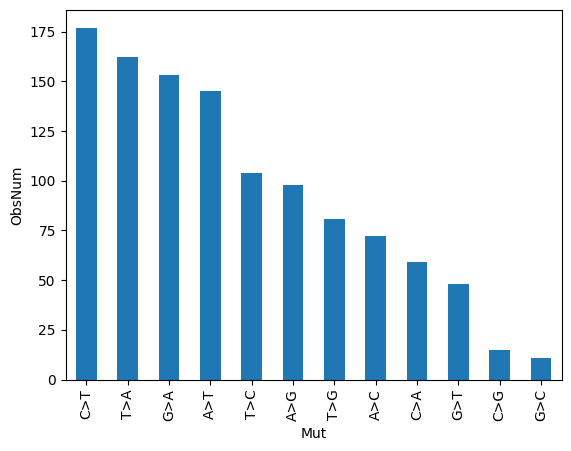

In [28]:
df_dnm[df_dnm.TYPE != 'INDEL'].Mut.value_counts().plot.bar()
plt.ylabel('ObsNum')